## Steps undertaken in this notebook:

1. Import and clean data using Abi's code
2. Split Dataframe in two, one for weekends and one for weekdays
3. Find average weekday and weekend volume for each station
4. Create new dataframe with difference between weekday and weekend avg volume
5. Sort by difference to find stations with highest proportion of commuters




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# Combine three weeks worth of MTA data from late April to early May

df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190427.txt')
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190504.txt')
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190511.txt')

df = df1.append([df2, df3])

In [3]:
# Data Cleaning 

df.columns = df.columns.str.strip()

df['DATETIME'] = df['DATE'] + ' ' + df['TIME']
df['DATETIME'] = pd.to_datetime(df['DATETIME'], format="%m/%d/%Y %H:%M:%S")

df.drop(columns=['DATE', 'TIME'], inplace=True)

df['DAY'] = df['DATETIME'].dt.day_name()

# Each turnstile can be indentified by a combination of the UNIT and SCP. Grouping by these two features allows us to get accurate
# entry and exit counts. 

df['ENTRY COUNT'] = df.groupby(['UNIT', 'SCP'])['ENTRIES'].transform(lambda x: x.diff())
df['EXIT COUNT'] = df.groupby(['UNIT', 'SCP'])['EXITS'].transform(lambda x: x.diff())

In [4]:
df = df[(df['ENTRY COUNT'] >= 0) & (df['EXIT COUNT'] >= 0)]

In [5]:
df = df[(df['ENTRY COUNT'] < 15000 ) & (df['EXIT COUNT'] < 15000)]

In [6]:
# Adding a new column which calculates the total volume for each row, i.e. entries and exits for the 4 hr timeframe
df['VOLUME'] = df['ENTRY COUNT'] + df['EXIT COUNT']
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,DATETIME,DAY,ENTRY COUNT,EXIT COUNT,VOLUME
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7026719,2382240,2019-04-20 04:00:00,Saturday,17.000,6.000,23.000
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7026737,2382269,2019-04-20 08:00:00,Saturday,18.000,29.000,47.000
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7026814,2382335,2019-04-20 12:00:00,Saturday,77.000,66.000,143.000
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7027007,2382395,2019-04-20 16:00:00,Saturday,193.000,60.000,253.000
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7027293,2382427,2019-04-20 20:00:00,Saturday,286.000,32.000,318.000


In [7]:
# Adding yet ANOTHER column for date, so that I can get daily total volumes
df['DATE'] = df['DATETIME'].dt.strftime('%m/%d/%Y')
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,DATETIME,DAY,ENTRY COUNT,EXIT COUNT,VOLUME,DATE
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7026719,2382240,2019-04-20 04:00:00,Saturday,17.000,6.000,23.000,04/20/2019
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7026737,2382269,2019-04-20 08:00:00,Saturday,18.000,29.000,47.000,04/20/2019
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7026814,2382335,2019-04-20 12:00:00,Saturday,77.000,66.000,143.000,04/20/2019
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7027007,2382395,2019-04-20 16:00:00,Saturday,193.000,60.000,253.000,04/20/2019
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,7027293,2382427,2019-04-20 20:00:00,Saturday,286.000,32.000,318.000,04/20/2019


In [8]:
# Splitting into two data frames
weekends = df[(df.DAY == "Saturday") | (df.DAY == "Sunday")]
weekdays = df[(df.DAY != "Saturday") & (df.DAY != "Sunday")]

Getting average volume, per station, per day, starting by getting the total volume for each station for each calendar day

In [9]:
weekday_totals = weekdays.groupby(['STATION', 'DATE']).agg({'VOLUME' : 'sum'})
weekend_totals = weekends.groupby(['STATION', 'DATE']).agg({'VOLUME' : 'sum'})
weekday_totals.reset_index()
weekend_totals.reset_index()

In [12]:
weekday_average = weekday_totals.groupby('STATION').mean()
weekend_average = weekend_totals.groupby('STATION').mean()

,VOLUME
STATION,
1 AV,38937.933
103 ST,52080.267
103 ST-CORONA,33784.533
104 ST,5230.600
110 ST,19662.667


In [14]:
weekday_average.reset_index()
weekend_average.reset_index()

,STATION,VOLUME
0,1 AV,17964.167
1,103 ST,29322.667
2,103 ST-CORONA,22017.167
3,104 ST,923.333
4,110 ST,11005.333
5,111 ST,13565.667
6,116 ST,33269.500
7,116 ST-COLUMBIA,11028.667
8,121 ST,952.333
9,125 ST,84999.167


In [26]:
daily_totals = weekdays.groupby('DAY').agg({'VOLUME' : 'sum'})

Overall it doesn't look like there is a huge amount of difference in volume throughout the week, although it is noticeable that there are more riders in the middle of the week. Enough to change our recommendations? I don't know. But maybe the difference is more noticeable for certain key stations?

In [28]:
daily_totals2 = weekdays.groupby(['STATION','DAY']).agg({'VOLUME' : 'sum'})

In [29]:
daily_totals2.loc[['GRD CNTRL-42 ST', '34 ST-PENN STA', 'FULTON ST', '34 ST-HERALD SQ', '23 ST']]

VOLUME
STATION         DAY                  
23 ST           Friday     561176.000
                Monday     545551.000
                Thursday   600611.000
                Tuesday    583033.000
                Wednesday  594831.000
34 ST-HERALD SQ Friday     686977.000
                Monday     643032.000
                Thursday   713283.000
                Tuesday    688543.000
                Wednesday  697782.000
34 ST-PENN STA  Friday     958609.000
                Monday     936398.000
                Thursday  1005842.000
                Tuesday    968317.000
                Wednesday  978111.000
FULTON ST       Friday     543979.000
                Monday     536783.000
                Thursday   583107.000
                Tuesday    564088.000
                Wednesday  571917.000
GRD CNTRL-42 ST Friday     844647.000
                Monday     835449.000
                Thursday   904209.000
                Tuesday    875517.000
                Wednesday  891070.000

There's a pretty consistent pattern where there are higher ridership numbers Tues-Thurs, but I'm not sure it would make enough of a difference at really high-volume stations. 

Also realizing that I need to redo my weekend-weekday difference to reflect that it is really a proportion of total volume

In [30]:
difference_ratio = weekday_average['VOLUME'] / weekend_average['VOLUME']

In [31]:
difference_ratio = pd.DataFrame(difference_ratio)

In [32]:
difference_ratio.reset_index()

,STATION,VOLUME
0,1 AV,2.168
1,103 ST,1.776
2,103 ST-CORONA,1.534
3,104 ST,5.665
4,110 ST,1.787
5,111 ST,1.657
6,116 ST,1.550
7,116 ST-COLUMBIA,2.161
8,121 ST,4.767
9,125 ST,1.573


In [33]:
difference_ratio.sort_values('VOLUME', ascending = False, inplace = True)

In [44]:
difference_ratio = pd.DataFrame(difference_ratio)

In [35]:
difference_ratio.loc['TIMES SQ-42 ST']

VOLUME   1.649
Name: TIMES SQ-42 ST, dtype: float64

So Times Square is below average for our "commuter station" metric. We can at least use it to eliminate some of the high volume stations.

In [51]:
diff2 = difference_ratio.loc[['GRD CNTRL-42 ST','34 ST-HERALD SQ','34 ST-PENN STA','42 ST-PORT AUTH','TIMES SQ-42 ST','14 ST-UNION SQ','47-50 STS ROCK',
                              'FULTON ST','59 ST COLUMBUS','PATH NEW WTC']]

In [ ]:
diff2.reset_index()

Text(0.5, 0, 'MTA-Wide Median = 1.96')

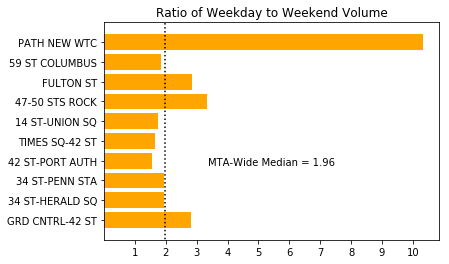

In [148]:
ticks_x = np.linspace(1,10,10)
new_x = diff2.index
new_y = diff2.VOLUME
plt.barh(new_x, new_y, color = 'orange')
plt.vlines(1.96,-3,15, linestyles = 'dotted')
plt.gca().set_ylim(-1, 10)
plt.xticks(ticks_x)
plt.title('Ratio of Weekday to Weekend Volume')
plt.xlabel('MTA-Wide Median = 1.96', labelpad = -100)

In [120]:
graph_weekday = weekday_average.loc[['GRD CNTRL-42 ST','34 ST-HERALD SQ','34 ST-PENN STA','42 ST-PORT AUTH','TIMES SQ-42 ST','14 ST-UNION SQ','47-50 STS ROCK',
                              'FULTON ST','59 ST COLUMBUS','PATH NEW WTC']]
graph_weekend = weekend_average.loc[['GRD CNTRL-42 ST','34 ST-HERALD SQ','34 ST-PENN STA','42 ST-PORT AUTH','TIMES SQ-42 ST','14 ST-UNION SQ','47-50 STS ROCK',
                              'FULTON ST','59 ST COLUMBUS','PATH NEW WTC']]

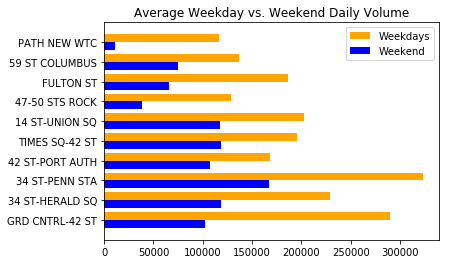

In [149]:
weekday_y = graph_weekday.VOLUME
weekday_x = graph_weekday.index
weekend_y = graph_weekend.VOLUME
weekend_x = graph_weekend.index

plt.gca().set_ylim(-1, 10)

plt.barh(weekday_x,weekday_y, height = 0.4, align = 'edge', color = 'orange')
plt.barh(weekend_x,weekend_y, height = -0.4, align = 'edge', color = 'b')
plt.title('Average Weekday vs. Weekend Daily Volume')
#plt.xlabel('Average Daily Entries and Exits')
plt.legend(['Weekdays','Weekend'])

In [147]:
difference_ratio.loc['23 ST']

VOLUME   2.224
Name: 23 ST, dtype: float64

23rd Street also has a good ratio

Ridership patterns during the week

In [ ]:
daily_totals = weekdays.groupby('DAY').agg({'VOLUME' : 'sum'})